## Plot best ML-Pipeline results

### Setup and Helper Functions

#### Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

from pathlib import Path

from biopsykit.classification.model_selection import SklearnPipelinePermuter

from pepbench.io import compute_abs_error

from pepbench.plotting.results import boxplot_algorithm_performance, _plot_helper_algorithm_performance

from fau_colors import cmaps, register_fausans_font

In [2]:
register_fausans_font()
plt.close("all")

palette = sns.color_palette(cmaps.faculties_light)
sns.set_theme(context="notebook", style="ticks", font="sans-serif", palette=palette)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "FAUSans Office"

palette

[(0.3803921568627451, 0.49019607843137253, 0.6313725490196078),
 (0.7137254901960784, 0.7607843137254902, 0.807843137254902),
 (0.996078431372549, 0.807843137254902, 0.4627450980392157),
 (0.42745098039215684, 0.8156862745098039, 0.9647058823529412),
 (0.6745098039215687, 0.8235294117647058, 0.4588235294117647),
 (0.8666666666666667, 0.45098039215686275, 0.48627450980392156)]

#### Datapaths

In [3]:
data_path = Path("../../../results/data/b-point")
model_path = Path("../../../results/models/b-point")
output_image_path = Path("Images/Paper")

### Load data

#### Load merged error metrics dataframe

In [4]:
merged_ml_results_b_point_metrics = pd.read_csv(data_path.joinpath("merged_ml_results_b_point_error_metrics_rr_only.csv"), index_col=[0,1,2,3])
merged_ml_results_b_point_metrics

arbol2017-isoelectric-crossings_error  \
participant condition phase         heartbeat_id_reference                                          
GDN0005     Dummy     HoldingBreath 0                                                       -50.0   
                                    1                                                        64.0   
                                    3                                                        -6.0   
                                    4                                                        -4.0   
                                    5                                                       -12.0   
...                                                                                           ...   
VP_032      tsst      Talk          39                                                      -25.0   
                                    40                                                       -9.0   
                                    41                                                       23.0   
                                    42                                                      -54.0   
                                    43                                                      -35.0   

                                                            arbol2017-isoelectric-crossings_rel_error  \
participant condition phase         heartbeat_id_reference                                              
GDN0005     Dummy     HoldingBreath 0                                                       -0.128866   
                                    1                                                        0.158416   
                                    3                                                       -0.015957   
                                    4                                                       -0.010256   
                                    5                                                       -0.031088   
...                                                                                               ...   
VP_032      tsst      Talk          39                                                      -0.080645   
                                    40                                                      -0.027950   
                                    41                                                       0.067647   
                                    42                                                      -0.173633   
                                    43                                                      -0.114007   

                                                            arbol2017-isoelectric-crossings_abs_error  \
participant condition phase         heartbeat_id_reference                                              
GDN0005     Dummy     HoldingBreath 0                                                            50.0   
                                    1                                                            64.0   
                                    3                                                             6.0   
                                    4                                                             4.0   
                                    5                                                            12.0   
...                                                                                               ...   
VP_032      tsst      Talk          39                                                           25.0   
                                    40                                                            9.0   
                                    41                                                           23.0   
                                    42                                                           54.0   
                                    43                                                           35.0   

              

#### Load merged results dataframe

In [5]:
merged_ml_results_b_point = pd.read_csv(data_path.joinpath("merged_ml_results_b_point_paper_rr_only.csv"), index_col=[0,1,2,3])
merged_ml_results_b_point

b_point_sample_reference  \
participant condition phase         heartbeat_id_reference                             
GDN0005     Dummy     HoldingBreath 0                                          388.0   
                                    1                                          404.0   
                                    3                                          376.0   
                                    4                                          390.0   
                                    5                                          386.0   
...                                                                              ...   
VP_032      tsst      Talk          39                                         310.0   
                                    40                                         322.0   
                                    41                                         340.0   
                                    42                                         311.0   
                                    43                                         307.0   

                                                            arbol2017-isoelectric-crossings  \
participant condition phase         heartbeat_id_reference                                    
GDN0005     Dummy     HoldingBreath 0                                                 438.0   
                                    1                                                 340.0   
                                    3                                                 382.0   
                                    4                                                 394.0   
                                    5                                                 398.0   
...                                                                                     ...   
VP_032      tsst      Talk          39                                                335.0   
                                    40                                                331.0   
                                    41                                                317.0   
                                    42                                                365.0   
                                    43                                                342.0   

                                                            arbol2017-second-derivative  \
participant condition phase         heartbeat_id_reference                                
GDN0005     Dummy     HoldingBreath 0                                             398.0   
                                    1                                             350.0   
                                    3                                             296.0   
                                    4                                             344.0   
                                    5                                             312.0   
...                                                                                 ...   
VP_032      tsst      Talk          39                                            276.0   
                                    40                                            298.0   
                                    41                                            300.0   
                                    42                                            324.0   
                                    43                                            313.0   

                                                            arbol2017-third-derivative  \
participant condition phase         heartbeat_id_reference                               
GDN0005     Dummy     HoldingBreath 0                                            394.0   
                                    1                                            244.0   
                                    3                                            386.0   
                                    4        

### Data cleaning

#### Create dictionary to select best ML-Pipeline and best traditional algorithm

In [6]:
algo_dict = {
    "drost2022_abs_error": "Dro22",
    "MinMax_None_RFR_RR-Interval-Include-Nan_abs_error": "MinMax RFR Include NaN",
}

#### Select and rename best algorithms

In [7]:
plot_data = merged_ml_results_b_point_metrics[algo_dict.keys()]
plot_data = plot_data.rename(columns=algo_dict)
plot_data

Dro22  \
participant condition phase         heartbeat_id_reference          
GDN0005     Dummy     HoldingBreath 0                        12.0   
                                    1                        16.0   
                                    3                        10.0   
                                    4                         6.0   
                                    5                         6.0   
...                                                           ...   
VP_032      tsst      Talk          39                        8.0   
                                    40                        0.0   
                                    41                        3.0   
                                    42                       43.0   
                                    43                       25.0   

                                                            MinMax RFR Include NaN  
participant condition phase         heartbeat_id_reference                          
GDN0005     Dummy     HoldingBreath 0                                    31.768000  
                                    1                                     0.648000  
                                    3                                     0.256000  
                                    4                                     1.293600  
                                    5                                     0.088444  
...                                                                            ...  
VP_032      tsst      Talk          39                                    0.040000  
                                    40                                    5.660000  
                                    41                                   15.168000  
                                    42                                   26.744000  
                                    43                                    0.900000  

[11239 rows x 2 columns]

### Residual Plots

#### Best ML-Pipeline against manually annotated reference by RR interval duration

In [8]:
lower_limit = 600
upper_limit = 1000
merged_ml_results_b_point = pd.read_csv(data_path.joinpath("merged_ml_results_b_point_paper_rr_only.csv"), index_col=[0,1,2,3])
merged_ml_results_b_point['heart_rate_bpm_estimated'] = 60000 / merged_ml_results_b_point['rr_interval_ms_estimated']

group_low_rr_interval_mask = merged_ml_results_b_point['rr_interval_ms_estimated'] < lower_limit
group_low_rr_interval = merged_ml_results_b_point.loc[group_low_rr_interval_mask]
group_medium_rr_interval_mask = ((merged_ml_results_b_point['rr_interval_ms_estimated'] >= lower_limit) & (merged_ml_results_b_point['rr_interval_ms_estimated'] <= upper_limit))
group_medium_rr_interval = merged_ml_results_b_point.loc[group_medium_rr_interval_mask]
group_high_rr_interval_mask = merged_ml_results_b_point['rr_interval_ms_estimated'] > upper_limit
group_high_rr_interval = merged_ml_results_b_point.loc[group_high_rr_interval_mask]

lower_limit_bpm = 60
upper_limit_bpm = 100
group_low_bpm_interval_mask = merged_ml_results_b_point['heart_rate_bpm_estimated'] < lower_limit_bpm
group_low_bpm_interval = merged_ml_results_b_point.loc[group_low_bpm_interval_mask]
group_medium_bpm_interval_mask = ((merged_ml_results_b_point['heart_rate_bpm_estimated'] >= lower_limit_bpm) & (merged_ml_results_b_point['heart_rate_bpm_estimated'] <= upper_limit_bpm))
group_medium_bpm_interval = merged_ml_results_b_point.loc[group_medium_bpm_interval_mask]
group_high_bpm_interval_mask = merged_ml_results_b_point['heart_rate_bpm_estimated'] > upper_limit_bpm
group_high_bpm_interval = merged_ml_results_b_point.loc[group_high_bpm_interval_mask]


residual_plot_data_bpm = merged_ml_results_b_point.copy()
residual_plot_data_bpm["Subset"] = "Medium HR"
residual_plot_data_bpm.loc[group_low_bpm_interval_mask, "Subset"] = "Low HR"
residual_plot_data_bpm.loc[group_high_bpm_interval_mask, "Subset"] = "High HR"

In [9]:
residual_plot_data_bpm["Subset"].value_counts()

Subset
Medium HR    6653
High HR      2483
Low HR       2103
Name: count, dtype: int64

#### Best ML-Pipeline against manually annotated reference by heart rate (HR)

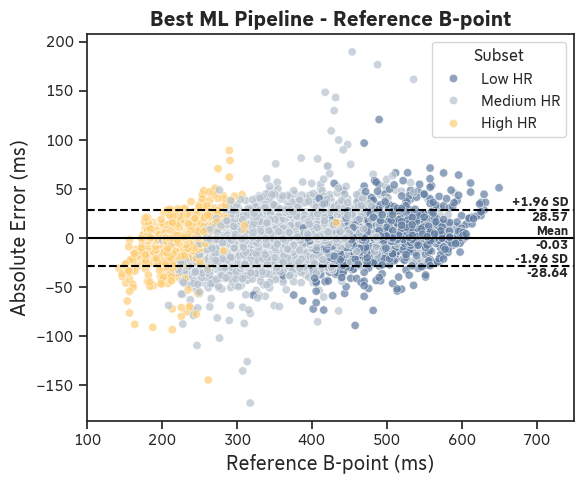

In [20]:
residual_plot_data_bpm['Diff. Reference - MinMax RFR'] = residual_plot_data_bpm['b_point_sample_reference'] - residual_plot_data_bpm['MinMax_None_RFR_RR-Interval-Include-Nan']

mean_diff = residual_plot_data_bpm['Diff. Reference - MinMax RFR'].mean()
std_diff = residual_plot_data_bpm['Diff. Reference - MinMax RFR'].std()

upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

fig, axs = plt.subplots(figsize=(6,5))
fig.patch.set_facecolor('none')
sns.scatterplot(data=residual_plot_data_bpm,
              x='b_point_sample_reference',
              y='Diff. Reference - MinMax RFR',
              alpha=0.7,
              hue='Subset',
              hue_order=['Low HR', 'Medium HR', 'High HR'],
              ax=axs,
)

axs.set_xlim(100,750)
# Add mean line
axs.axhline(mean_diff, color='black', linestyle='-', linewidth=1.5)
axs.text(axs.get_xlim()[1] * 0.99, mean_diff, f'Mean\n{mean_diff:.2f}', va='center', ha='right', fontsize=9, fontdict={'weight': 'bold'})

# Add 1.96 SD lines (Limits of Agreement)
axs.axhline(upper_limit, color='black', linestyle='--', linewidth=1.5)
axs.text(axs.get_xlim()[1] * 0.99, upper_limit, f'+1.96 SD\n{upper_limit:.2f}', va='center', ha='right', fontsize=9, fontdict={'weight': 'bold'})

axs.axhline(lower_limit, color='black', linestyle='--', linewidth=1.5)
axs.text(axs.get_xlim()[1] * 0.99, lower_limit, f'-1.96 SD\n{lower_limit:.2f}', va='center', ha='right', fontsize=9, fontdict={'weight': 'bold'})

axs.set_ylabel("Absolute Error (ms)", fontdict={"size": 14.5})
axs.set_xlabel("Reference B-point (ms)", fontdict={"size": 14.5})
axs.set_title("Best ML Pipeline - Reference B-point", fontdict={"weight": "bold", "size": 15})
fig.tight_layout()
plt.savefig("C:/Users/sebas/OneDrive/Dokumente/Uni/Master/Research Internship/Paper/ML Paper/Figures/residualplot_abs_error_per_hr.svg", dpi=300, bbox_inches="tight", transparent=False)
plt.show()

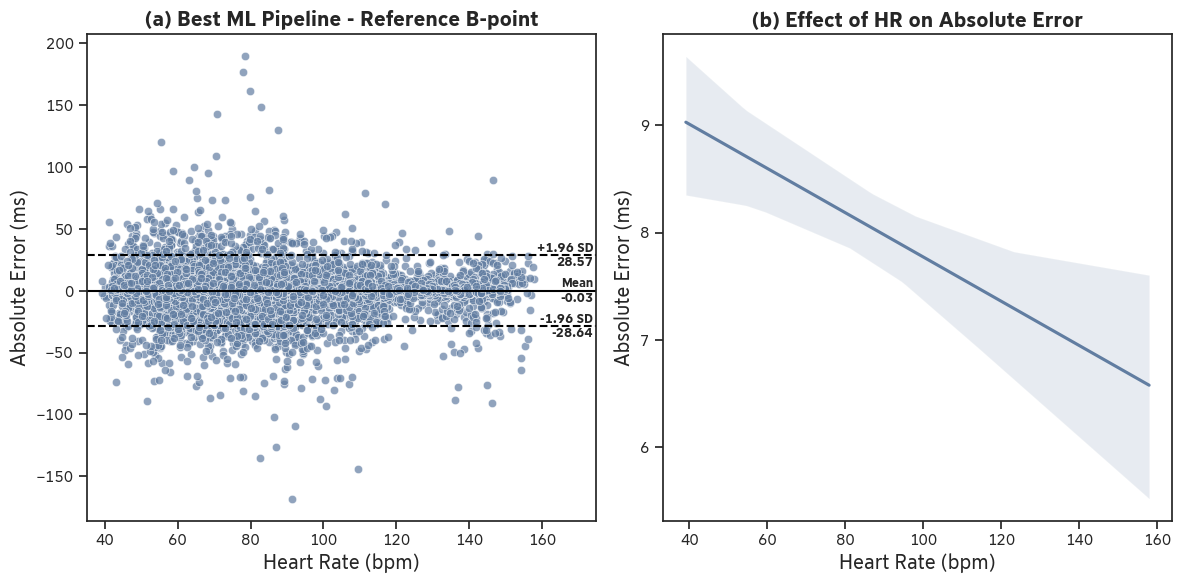

In [19]:
residual_plot_data_bpm['Diff. Reference - MinMax RFR'] = residual_plot_data_bpm['b_point_sample_reference'] - residual_plot_data_bpm['MinMax_None_RFR_RR-Interval-Include-Nan']

mean_diff = residual_plot_data_bpm['Diff. Reference - MinMax RFR'].mean()
std_diff = residual_plot_data_bpm['Diff. Reference - MinMax RFR'].std()

upper_limit = mean_diff + 1.96 * std_diff
lower_limit = mean_diff - 1.96 * std_diff

fig, axs = plt.subplots(1,2, figsize=(12,6))
fig.patch.set_facecolor('none')
sns.scatterplot(data=residual_plot_data_bpm,
              x='heart_rate_bpm_estimated',
              y='Diff. Reference - MinMax RFR',
              alpha=0.7,
              ax=axs[0],
)
# Add mean line
axs[0].set_xlim(35,175)
axs[0].axhline(mean_diff, color='black', linestyle='-', linewidth=1.5)
axs[0].text(axs[0].get_xlim()[1] * 0.995, mean_diff, f'Mean\n{mean_diff:.2f}', va='center', ha='right', fontsize=9, fontdict={'weight': 'bold'})

# Add 1.96 SD lines (Limits of Agreement)
axs[0].axhline(upper_limit, color='black', linestyle='--', linewidth=1.5)
axs[0].text(axs[0].get_xlim()[1] * 0.995, upper_limit, f'+1.96 SD\n{upper_limit:.2f}', va='center', ha='right', fontsize=9, fontdict={'weight': 'bold'})

axs[0].axhline(lower_limit, color='black', linestyle='--', linewidth=1.5)
axs[0].text(axs[0].get_xlim()[1] * 0.995, lower_limit, f'-1.96 SD\n{lower_limit:.2f}', va='center', ha='right', fontsize=9, fontdict={'weight': 'bold'})

# axs[0].set_ylabel("Reference B-point - Best ML Pipeline (ms)", fontdict={"size": 14.5})
axs[0].set_ylabel("Absolute Error (ms)", fontdict={"size": 14.5})
axs[0].set_xlabel("Heart Rate (bpm)", fontdict={"size": 14.5})
axs[0].set_title("(a) Best ML Pipeline - Reference B-point", fontdict={"weight": "bold", "size": 15})


residual_plot_data_bpm['Diff. Reference - MinMax RFR'] = np.abs(residual_plot_data_bpm['Diff. Reference - MinMax RFR'])
sns.regplot(
    x='heart_rate_bpm_estimated',
    y='Diff. Reference - MinMax RFR',
    data=residual_plot_data_bpm,
    lowess=False,
    scatter_kws={'alpha':0.1},
    line_kws={'color':palette[0]},
    x_ci="sd",
    ci=100,
    scatter=False,
    ax=axs[1],
)
axs[1].set_ylabel("Absolute Error (ms)", fontdict={"size": 14.5})
axs[1].set_xlabel("Heart Rate (bpm)", fontdict={"size": 14.5})
axs[1].set_title("(b) Effect of HR on Absolute Error", fontdict={"weight": "bold", "size": 15})
fig.tight_layout()
plt.savefig("C:/Users/sebas/OneDrive/Dokumente/Uni/Master/Research Internship/Paper/ML Paper/Figures/regressionplot_abs_error_per_hr.pdf", dpi=300, bbox_inches="tight", transparent=False)
plt.show()
